<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np
import re
from collections import Counter
import shutil

In [2]:
os.chdir(r'/content')

content_dir = r'/content/CAPTUM/'

# Remove if files already exist
while os.path.exists(content_dir): 
    shutil.rmtree(content_dir)


!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (538/538), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 538 (delta 38), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (538/538), 11.72 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (38/38), done.


# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [3]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)
file_dir = r'/content/CAPTUM/files'
os.chdir(file_dir)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [4]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [5]:
fileNameTags = list(map(lambda fn: fn.replace('', '+').split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [6]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Name,Tags,Year,Authors,Content
0,CAPTUM_ASST_serverity_Ye 2016.pdf_out_text.txt,8bb3d9ade4285aaba63ba1f380f1e26e,Ye 2016.pdf,"[ASST+, serverity+]",2016,Ye,Original Article\n\nAllergy Asthma Immunol Res...
1,CAPTUM_D-Dimer_Omalizumab_Marzano 2018.pdf_out...,716f3d50325465fea4c423cb24be0d7e,Marzano 2018.pdf,"[D-Dimer, Omalizumab]",2018,Marzano,DOI: 10.1111/jdv.15350 JEADV\n\nORIGINAL ARTIC...
2,CAPTUM_BHRA_Basophil_Kolkhir 2020.pdf_out_text...,9e586bf2dcefa054c6dc08585f7c785b,Kolkhir 2020.pdf,"[BHRA, Basophil]",2020,Kolkhir,"Original Article\n\n \n\nEosinopenia, in Chron..."
3,CAPTUM_Thyroglobulin_Allergic Diseases_Cugno 2...,e71401851a24fb19473817bf0715e0bd,Cugno 2018.pdf,"[Thyroglobulin, Allergic Diseases]",2018,Cugno,PROF. MASSIMO CUGNO (Orcid ID : 0000-0002-9918...
4,CAPTUM_Basophil_Antihistamine_Dyke 2008.pdf_ou...,139eb37a35156919a40ef05cc5ff7384,Dyke 2008.pdf,"[Basophil, Antihistamine]",2008,Dyke,doi: 10.1111/).1365-2222.2007.02864.x\n\n \n\n...
...,...,...,...,...,...,...,...
1041,CAPTUM_D-Dimer_Allergic Diseases_Yalcin 2013.p...,52bea352c4d316bcfb27bbd45bac9cb1,Yalcin 2013.pdf,"[D-Dimer, Allergic Diseases]",2013,Yalcin,Original Research\n\n \n\nD-dimer levels decre...
1042,CAPTUM_BAT_Severity_Uysal 2016.pdf_out_text.txt,a86431127af09c8de0863de2f261a361,Uysal 2016.pdf,"[BAT, Severity]",2016,Uysal,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...
1043,CAPTUM_anti-FcεRI_Basophil_Sterba 2015.pdf_out...,2ae9ea0ea1476b1eaa49ffd4c2b69f2e,Sterba 2015.pdf,"[anti-FcεRI, Basophil]",2015,Sterba,jduosnueyy souiny yduosnueyy soulny jduosnueyy...
1044,CAPTUM_D-Dimer_Severity_Asero 2020.pdf_out_tex...,84a9ba4506b92b3a419c7c1d0b8c3f57,Asero 2020.pdf,"[D-Dimer, Severity]",2020,Asero,ARE CURRENTLY AVAILABLE BIOMARKERS USEFUL TO D...


In [7]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [8]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [9]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Es werden Füllwörter entfernt.

In [10]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        # Wort unter 3 Zeichen -> weg
        if len(word) < 3:
          next
        # Mehr als eine Ziffer -> weg
        elif sum(c.isdigit() for c in word)>1:
          next
        # nicht in Stopword Liste -> behalten
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [11]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [12]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [13]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al', 'fig', 
                        'point', 'data', 'patient', 'result', 'study', 'disease', 
                        'result', 'group', 'table', 'figure', 'patient'):
      next
    else:
      filtered_text.append(word)

  counter = Counter(filtered_text)
  filtered_text = [key for key, val in counter.items() if val > 1]

  return filtered_text

In [14]:
def remove_doi(text):
  doi_regex = r"10.\d{4,9}\/[-._;()\/:A-Z0-9]+$"
  new_text = re.sub(doi_regex, '', text, flags=re.IGNORECASE)
  return new_text

In [15]:
removeWords(['csu', 'TEST', 'DOI', 'doi', 'al', 'DOI'])

[]

In [16]:
def normalize_text(tokenizer, text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  # remove doi
  text = remove_doi(text)

  tokenized_text = tokenizer.tokenize(text)

  tokenized_text = removeWords(tokenized_text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)

  text = " ".join(tokenized_text)
  return text

In [17]:
def remove_word_in_every_corpus(corpus, series):
  words = set(series)
  print(words)
  return




  new_corpus = []
  for word in corpus:
    in_every_corpus = True
    for element in series:
      if not word in element:
        in_every_corpus = False
    if in_every_corpus:
      new_corpus += word
  return new_corpus

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [63]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer, c))

# Corpus aufräumen 
#df['Corpus'] = df['Corpus'].apply(lambda c: remove_word_in_every_corpus(c, df['Content']))


regex_tokenizer2 = nltk.RegexpTokenizer('\w+[\.,]{0,1}')
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer2, c))


In [21]:
corpus_list = df['Content'].to_list()
remove_word_in_every_corpus('', corpus_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Ye,2016,"ASST+, serverity+, Ana",Original Article\n\nAllergy Asthma Immunol Res...,original article allergy asthma immunol re mar...,original article allergy asthma immunol res. m...
1,Marzano,2018,"D-Dimer, Omalizumab, Allergic Diseases, Anti-I...",DOI: 10.1111/jdv.15350 JEADV\n\nORIGINAL ARTIC...,jeadv predictor response omalizumab relapse ch...,jeadv predictor response omalizumab relapse ch...
2,Kolkhir,2020,"BHRA, Basophil, ASST+, omalizumab, Eosinophil,...","Original Article\n\n \n\nEosinopenia, in Chron...",article eosinopenia chronic spontaneous associ...,"article eosinopenia, chronic spontaneous urtic..."
3,Cugno,2018,"Thyroglobulin, Allergic Diseases, Omalizumab, ...",PROF. MASSIMO CUGNO (Orcid ID : 0000-0002-9918...,massimo cugno orcid riccardo asero article edi...,massimo cugno orcid riccardo asero article edi...
4,Dyke,2008,"Basophil, Antihistamine",doi: 10.1111/).1365-2222.2007.02864.x\n\n \n\n...,clinical experimental allergy author journal c...,"clinical experimental allergy, author journal ..."
...,...,...,...,...,...,...
449,Sarti,2020,"Severity, Omalizumab",Received: 8 March 2020 Revised: 28 June 2020 ®...,received pai original article wiley efficacy t...,received pai. original article wiley efficacy ...
450,Llanos,2019,"Allergic Diseases, Omalizumab",Journal of Asthma and Allergy\n\n3\n\nDove\n\n...,journal asthma allergy dove original research ...,journal asthma allergy dove original research ...
451,Seth,2016,"Omalizumab, Cyclosporine",Original Article\n\n \n\nThe Comparative Safet...,article comparative safety multiple alternativ...,article comparative safety multiple alternativ...
452,Asero,2004,"ASST+, BHRA",Clin Exp Allergy 2004; 34:11 11-1114 doi:10.11...,clin exp allergy assessment histamine releasin...,clin exp allergy assessment histamine releasin...


# Wordcloud


In [ ]:
!pip install wordcloud

from wordcloud import WordCloud

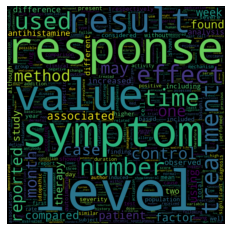

In [ ]:
words = ' '.join(list(df['Corpus']))
wordcloud = WordCloud(width=1000, height=1000, max_words=1000).generate(words)
wordcloud.to_file("../../first_review.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Distinct Tags

In [ ]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Angioedema
Antihistamine
Omalizumab
Anti-IgE
Severity
Total IgE
TPO
anti-FcεRI
Ana
ASST+
CRP
serverity+
duration
Basophil count
BAT
Eosinophil count
Tissue factor
omalizumab
Duration
thyroglobulin
Allergic Diseases
dsDNA
Thyroglobulin
angioedema
anti-TPO IgE ratio+
Basophil
BHRA
Cyclosporine
D-Dimer
IL-24
cyclosporine
Eosinophil
ANA


# Algorithmen anwenden

### ScispaCy

In [ ]:
!pip install spacy==3.1.0
!pip install scispacy==0.4.0
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz

     |████████████████████████████████| 6.4 MB 21.4 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 621 kB 42.0 MB/s 
     |████████████████████████████████| 456 kB 54.9 MB/s 
     |████████████████████████████████| 10.1 MB 62.5 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 44 kB 2.2 MB/s 
     |████████████████████████████████| 6.3 MB 

In [ ]:
import spacy
import scispacy

from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
from collections import OrderedDict, Counter
from pprint import pprint

nlp = spacy.load('en_ner_bionlp13cg_md')

In [ ]:
def display_entities(model, document):
  nlp = spacy.load(model)
  doc = nlp(document)
  #displacy_image = displacy.render(doc, jupyter=True, style='ent')
  entity_and_label = set([(X.text, X.label_) for X in doc.ents])
  return displacy_image, entity_and_label

In [ ]:
#As an example print the first Corpus from the df with the recogniced entities.
entities = display_entities('en_ner_bionlp13cg_md', df['Corpus_w_Punctuation'][0])

In [ ]:
entities_dataframe = pd.DataFrame(entities[1],columns=['Entity','Label'])
entities

(None,
 {('aair', 'SIMPLE_CHEMICAL'),
  ('aairorg', 'GENE_OR_GENE_PRODUCT'),
  ('ajou', 'GENE_OR_GENE_PRODUCT'),
  ('antibody ana', 'GENE_OR_GENE_PRODUCT'),
  ('antihistamine', 'SIMPLE_CHEMICAL'),
  ('antihistamine iii', 'SIMPLE_CHEMICAL'),
  ('arch', 'ORGAN'),
  ('aspirin', 'SIMPLE_CHEMICAL'),
  ('ass', 'ORGANISM'),
  ('asst', 'GENE_OR_GENE_PRODUCT'),
  ('blood', 'ORGANISM_SUBSTANCE'),
  ('crp', 'GENE_OR_GENE_PRODUCT'),
  ('cuqol prednisolone', 'GENE_OR_GENE_PRODUCT'),
  ('cyclosporine', 'SIMPLE_CHEMICAL'),
  ('eaaci edf wao', 'GENE_OR_GENE_PRODUCT'),
  ('female', 'ORGANISM'),
  ('francis', 'CELLULAR_COMPONENT'),
  ('giménez bousquet urticaria', 'GENE_OR_GENE_PRODUCT'),
  ('grattan', 'GENE_OR_GENE_PRODUCT'),
  ('greave dermatol hiragun', 'GENE_OR_GENE_PRODUCT'),
  ('histamine leukotriene', 'SIMPLE_CHEMICAL'),
  ('igg antibodies', 'GENE_OR_GENE_PRODUCT'),
  ('immunol res', 'SIMPLE_CHEMICAL'),
  ('ool', 'GENE_OR_GENE_PRODUCT'),
  ('oral', 'ORGAN'),
  ('patient', 'ORGANISM'),
  ('patient

## Bag of Words
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [ ]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 _http
1 aair
2 aairorg
3 able
4 academy
5 accepted
6 according
7 achieve
8 achieved
9 achieving
10 acta


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


Angioedema
Antihistamine
Omalizumab
Anti-IgE
Severity
Total IgE
TPO
anti-FcεRI
Ana
ASST+
CRP
serverity+
duration
Basophil count
BAT
Eosinophil count
Tissue factor
omalizumab
Duration
thyroglobulin
Allergic Diseases
dsDNA
Thyroglobulin
angioedema
anti-TPO IgE ratio+
Basophil
BHRA
Cyclosporine
D-Dimer
IL-24
cyclosporine
Eosinophil
ANA


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus_w_Punctuation'])

In [ ]:
sorted(distinct_topics)


['activation',
 'activity',
 'airway',
 'allergy',
 'analysis',
 'angioedema',
 'antibody',
 'antihistamine',
 'asst',
 'asthma',
 'basophil',
 'cell',
 'cells',
 'cohort',
 'concentration',
 'confidence',
 'content',
 'control',
 'correlation',
 'difference',
 'dimension',
 'disease',
 'dose',
 'dosing',
 'education',
 'effect',
 'eosinophil',
 'factor',
 'function',
 'ige',
 'individual',
 'inflammation',
 'level',
 'lloq',
 'male',
 'manuscript',
 'mechanism',
 'mediated',
 'medimmune',
 'method',
 'model',
 'month',
 'mouse',
 'national',
 'omalizumab',
 'pathway',
 'patient',
 'patients',
 'placebo',
 'plate',
 'process',
 'protein',
 'psoriasis',
 'reaction',
 'receptor',
 'respectively',
 'response',
 'scale',
 'score',
 'screening',
 'secretion',
 'serum',
 'severity',
 'skin',
 'standard',
 'study',
 'subject',
 'symptom',
 'syndrome',
 'test',
 'therapy',
 'treatment',
 'type',
 'urticaria',
 'virginia',
 'week',
 'year']

### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [ ]:
!pip3 install bertopic[all]
from bertopic import BERTopic

^C


ModuleNotFoundError: ignored

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Content']))

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq.head()

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

In [ ]:
topic_model.visualize_topics()

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Content'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 6.4 MB 40.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3 MB 29.9 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 2.6 MB 28.4 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
     |████████████████████████████████| 636 kB 20.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
/bin/bash: 1.0.0: No such file or directory


In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
docs = list(df.loc[:, "Content"].values)
docs[:5]

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

In [ ]:
model.get_num_topics()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

In [58]:
#@title Dateiinhalt, Korpus oder Korpus mit Satzzeichen
src = 'Corpus_w_Punctuation' #@param {type:"string"}
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df[src].values)

In [59]:
len(tfidfconvert.vocabulary_)

15875

In [60]:
words_transformed = tfidfconvert.transform(df['Corpus'].values)

### K-Means Clustering

In [61]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen und anschließend plotten

In [65]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


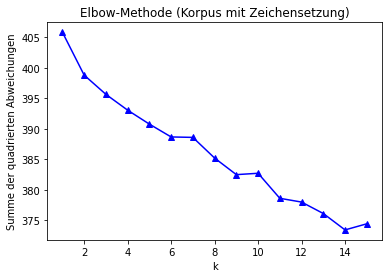

In [66]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Summe der quadrierten Abweichungen')
plt.title('Elbow-Methode (Korpus mit Zeichensetzung)')
plt.show()

Wortsammlungen erstellen durch angabe der Idealen Clusterzahl im Formularfeld

In [54]:
#@title Anzahl der Cluster gem. Elbow-Curve
k = 6#@param {type:"integer"}

km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=1)

In [56]:
#https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
km = KMeans(n_clusters=k)
km = km.fit(words_transformed)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidfconvert.get_feature_names()
for i in range(k):
  print("Cluster %d:" % i, end='')
  for ind in order_centroids[i, :20]:
    print(' %s' % terms[ind], end='')
  print()

Cluster 0: donor basophil assay cell serum concentration antibody incubated control receptor autoantibody incubation sample vitro human subject functional experiment method affinity
Cluster 1: antihistamine score guideline effect week symptom month trial therapy treatment day medication improvement efficacy time refractory safety period omalizumab dose
Cluster 2: concentration cell control correlation level cytokine protein value difference factor marker test serum score inflammatory inflammation kasperska reactive zajac response
Cluster 3: food child adult test year symptom case infection drug antihistamine condition month medication cause antibody factor oral corticosteroid time reaction
Cluster 4: cell basophil antibody test wheal control level value factor difference serum correlation marker autoantibody eosinophil week receptor mechanism score finding
Cluster 5: dugnano paderno carlo clinica allergologia dimer ambulatorio san riccardo crp italy elevated marzano cugno showing excel



# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper